In [1]:
!pip install Tashaphyne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 7.8 MB/s eta 0:00:00


In [2]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from tashaphyne.stemming import ArabicLightStemmer
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import re

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Make a list of stories data only
csv_files = [csv_file for csv_file in glob.glob('/kaggle/input/hespress/*.csv') if 'stories' in csv_file]

# Create an empty DataFrame for train & test data
train_df = pd.DataFrame()
test_df = pd.DataFrame()

# Iterate over the CSV files and add them to the DataFrames
for csv_file in csv_files:
    df_temp = pd.read_csv(csv_file, index_col=0, encoding="utf-8")
    df_temp_test = df_temp.sample(frac=.2, random_state=23)
    test_df = pd.concat([test_df, df_temp_test], ignore_index=True)
    train_df = pd.concat([train_df, df_temp.drop(df_temp_test.index)], ignore_index=True)

# Show the train DataFrame
train_df

,id,title,date,author,story,topic
0,9d9ebd0204f811eb92ec646e69d991ea,"شهادة طبيب جراح ""تورط"" قنصلا بتر أصبع مسنة",الجمعة 02 أكتوبر 2020 - 20:08,هسبريس من الدار البيضاء,قررت الغرفة الجنائية بمحكمة الاستئناف بمدينة ا...,faits-divers
1,9e96ecc604f811eb836a646e69d991ea,"إحباط تهريب أكثر من طن من ""الحشيش"" بأكادير",الجمعة 02 أكتوبر 2020 - 19:37,رشيد بيجيكن من أكادير,تمكنت المصلحة الولائية للشرطة القضائية بمدينة ...,faits-divers
2,9fc1ec4204f811eb8619646e69d991ea,كمين أمن الصويرة يسقط شبكة هجرة غير نظامية,الجمعة 02 أكتوبر 2020 - 18:35,ابراهيم مغراوي من مراكش,أوقفت عناصر فرقة الشرطة القضائية بالمنطقة الإق...,faits-divers
3,a0a2fa9c04f811eb8580646e69d991ea,"""تلميذة زاكورة"" تتهم زوج أختها باستغلالها جنسيا",الجمعة 02 أكتوبر 2020 - 14:20,هسبريس من زاكورة,كشف مصدر أمني مسؤول أن التلميذة المتحدرة من جم...,faits-divers
4,a2d0124a04f811eba88f646e69d991ea,"""أحجار كريمة مزيفة"" تورط أشخاصا بمدينة أكادير",الجمعة 02 أكتوبر 2020 - 10:05,رشيد بيجيكن من أكادير,تمكنت عناصر المصلحة الولائية للشرطة القضائية ب...,faits-divers
...,...,...,...,...,...,...
8795,a45c1b8c04f311eb9d40646e69d991ea,خالد العيني .. بصمات مغربي على الإعلام والاستث...,الأحد 13 ماي 2018 - 06:00,هسبريس ـ ط.العاطفي | أ.الخياري,حرصت عينا خالد العيني على النظر بعيدا وأنامله ...,marocains-du-monde
8796,a56180e804f311eb99f7646e69d991ea,188 أستاذا لتدريس العربية لأبناء مغاربة العالم,السبت 12 ماي 2018 - 23:25,هسبريس من الرباط,أعلنت وزارة التربية الوطنية والتكوين المهني وا...,marocains-du-monde
8797,a67a5ac604f311eb983a646e69d991ea,الحروشي .. قاض مغربي ينتصر للعدل في المحكمة ال...,السبت 12 ماي 2018 - 06:00,هسبريس ـ ط.العاطفي | أ.الخياري,لا يلفظ اسم العربي الحروشي في سلطنة عمان إلا و...,marocains-du-monde
8798,a788167404f311eb91c0646e69d991ea,غزلان الصيابري .. مغربية تعتلي قمّة المال والأ...,الجمعة 11 ماي 2018 - 06:00,هسبريس ـ ط.العاطفي | أ.الخياري,طال المقام بالمغربية غزلان الصيابري في تجربة ا...,marocains-du-monde


In [4]:
# Shape of our data
train_df.shape, test_df.shape

((8800, 6), (2200, 6))

In [5]:
# Check for class imbalance
train_df.topic.value_counts(), "", test_df.topic.value_counts()

(faits-divers          800
 art-et-culture        800
 regions               800
 sport                 800
 medias                800
 economie              800
 tamazight             800
 societe               800
 orbites               800
 politique             800
 marocains-du-monde    800
 Name: topic, dtype: int64,
 '',
 faits-divers          200
 art-et-culture        200
 regions               200
 sport                 200
 medias                200
 economie              200
 tamazight             200
 societe               200
 orbites               200
 politique             200
 marocains-du-monde    200
 Name: topic, dtype: int64)

In [6]:
# Remove irelevent columns
train_df = train_df[['story', 'topic']]
test_df = test_df[['story', 'topic']]
train_df.head()

,story,topic
0,قررت الغرفة الجنائية بمحكمة الاستئناف بمدينة ا...,faits-divers
1,تمكنت المصلحة الولائية للشرطة القضائية بمدينة ...,faits-divers
2,أوقفت عناصر فرقة الشرطة القضائية بالمنطقة الإق...,faits-divers
3,كشف مصدر أمني مسؤول أن التلميذة المتحدرة من جم...,faits-divers
4,تمكنت عناصر المصلحة الولائية للشرطة القضائية ب...,faits-divers


In [7]:
# Define function for processing and cleaning arabic data
def process_text(text):
  # Remove diacritics
  text = text.replace("َ", "").replace("ُ", "").replace("ِ", "").replace("ْ", "")
  
  # Remove all the special characters
  text = re.sub(r'\W', ' ', text)

  # Normalize the input text
  text = text.lower()

  # Tokenize the input text
  words = word_tokenize(text)

  # Remove stop words and stem the remaining words
  stop_words = nltk.corpus.stopwords.words('arabic')
  stemmer = ArabicLightStemmer()
  stemmed_words = [stemmer.light_stem(word) for word in words if word not in stop_words]
    
  # Return output
  return ' '.join(stemmed_words)

In [8]:
# Apply proccess function on story data
train_df['story_cleaned'] = train_df['story'].apply(process_text)
test_df['story_cleaned'] = test_df['story'].apply(process_text)

train_df[['story', 'story_cleaned']]

/tmp/ipykernel_20/108121024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['story_cleaned'] = train_df['story'].apply(process_text)


,story,story_cleaned
0,قررت الغرفة الجنائية بمحكمة الاستئناف بمدينة ا...,قرر غرف جنائ محكم استئناف مدين دار بيضاء مواصل...
1,تمكنت المصلحة الولائية للشرطة القضائية بمدينة ...,تمكن مصلح ولائ شرط قضائ مدين كادير ضوء معلوم د...
2,أوقفت عناصر فرقة الشرطة القضائية بالمنطقة الإق...,قف عناصر رق شرط قضائ منطق إقليم أمن مدين صوير ...
3,كشف مصدر أمني مسؤول أن التلميذة المتحدرة من جم...,شف مصدر من مسؤول تلميذ متحدر جماع نزول إقليم ز...
4,تمكنت عناصر المصلحة الولائية للشرطة القضائية ب...,تمكن عناصر مصلح ولائ شرط قضائ مدين كادير أربعا...
...,...,...
8795,حرصت عينا خالد العيني على النظر بعيدا وأنامله ...,حرص عي خالد عين نظر عيدا نامل تفحص أمام عتاد ب...
8796,أعلنت وزارة التربية الوطنية والتكوين المهني وا...,علن زار ترب وطن تكو مهن تعليم عال بحث علم قطاع...
8797,لا يلفظ اسم العربي الحروشي في سلطنة عمان إلا و...,لفظ سم عرب حروش سلطن عم مقترن عبار ضيل قاض طيل...
8798,طال المقام بالمغربية غزلان الصيابري في تجربة ا...,طال مقام مغرب غزل صيابر تجرب هجر صل عد سن يف إ...


In [9]:
# Seperate features and target values for train and test data

X_train = train_df['story_cleaned']
y_train = train_df['topic']

X_test = test_df['story_cleaned']
y_test = test_df['topic']

X_train.shape , y_train.shape

((8800,), (8800,))

In [10]:
# Apply Logistic Regression pipeline
text_clf_log = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression()),])
text_clf_log.fit(X_train, y_train)

log_preds = text_clf_log.predict(X_test)
print("Accuracy score using Logistic Regression is: {}%".format(accuracy_score(y_test, log_preds)*100))

Accuracy score using Logistic Regression is: 84.0909090909091%


In [11]:
# Apply LinearSVC pipeline
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LinearSVC()),])
text_clf_lsvc.fit(X_train, y_train)

lsvc_preds = text_clf_lsvc.predict(X_test)
print("Accuracy score using Logistic Regression is: {}%".format(accuracy_score(y_test, lsvc_preds)*100))

Accuracy score using Logistic Regression is: 84.5909090909091%


In [12]:
# Apply SVC pipeline
text_clf_svc = Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC()),])
text_clf_svc.fit(X_train, y_train)

svc_preds = text_clf_svc.predict(X_test)
print("Accuracy score using Logistic Regression is: {}%".format(accuracy_score(y_test, svc_preds)*100))
print(classification_report(y_test, svc_preds))

Accuracy score using Logistic Regression is: 85.31818181818181%
                    precision    recall  f1-score   support

    art-et-culture       0.83      0.88      0.85       200
          economie       0.83      0.89      0.86       200
      faits-divers       0.96      0.93      0.95       200
marocains-du-monde       0.88      0.88      0.88       200
            medias       0.96      0.90      0.93       200
           orbites       0.68      0.70      0.69       200
         politique       0.82      0.80      0.81       200
           regions       0.81      0.77      0.79       200
           societe       0.69      0.75      0.72       200
             sport       0.99      0.99      0.99       200
         tamazight       0.96      0.92      0.94       200

          accuracy                           0.85      2200
         macro avg       0.86      0.85      0.85      2200
      weighted avg       0.86      0.85      0.85      2200



**Precision**: Precision measures the accuracy of positive predictions made by the model. In the context of this task, it represents the proportion of correctly classified instances of a class concerning all instances classified as that class. For example, for the "sport" class, the model correctly predicted 99% of the examples it classified as "sport."

**Recall**: Recall, also known as sensitivity or true positive rate, measures the ability of the model to capture positive instances of a class. In the context of this task, it represents the proportion of correctly classified instances of a class concerning all actual instances of that class. For example, for the "tamazight" class, the model captured 92% of all actual "tamazight" examples.

**F1-Score**: The F1-score is the harmonic mean of precision and recall. It provides a balance between the two metrics and is useful when dealing with imbalanced datasets. A high F1-score indicates a good balance between precision and recall. For instance, the "sport" class has an F1-score of 0.99, indicating a very high balance between precision and recall.

**Accuracy**: Accuracy measures the overall correctness of the model's predictions. It is the ratio of correctly classified examples to the total number of examples. In this case, the model achieved an accuracy of 85%, meaning 85% of the test examples were correctly classified.

Text(0.5, 1.0, 'Confusion Matrix')

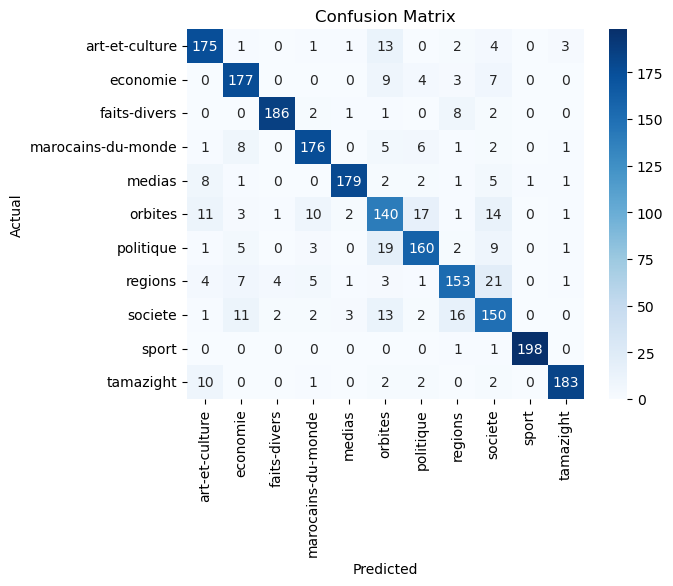

In [13]:
# Plot confusion matrix
conf_mat = confusion_matrix(y_test, svc_preds)
labels = ['art-et-culture', 'economie', 'faits-divers', 'marocains-du-monde', 'medias', 'orbites', 'politique', 'regions', 'societe', 'sport', 'tamazight']

sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d', xticklabels=labels, yticklabels=labels)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")

In general, the confusion matrix looks good (clear diagonal that represents correct classifications). Nevertheless, there are cases were the complaint was classified in a wrong class.

**Enhancements for Better Results:**
* Collect More Data
* Advanced Feature Engineering
* Hyperparameter Tuning
* Apply Advanced Algorithms ex: Deep Learning